In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/ANN Competition/Homework1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1ckveNGqgPJLZP8oVcHRvQStV1LtkEwq1/ANN Competition/Homework1


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers as tfkl
from keras.callbacks import TensorBoard
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
!pip install keras_cv
import keras_cv
!pip install imblearn
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 48.1 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
#inspect data
data = np.load('public_data.npz', allow_pickle=True)
print(data['data'].shape)
print(data['labels'].shape)

# Find unique values and their counts in the 'labels'
unique, count = np.unique(data['labels'], return_counts=True)

# Print unique values and their corresponding sample counts
print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

(5200, 96, 96, 3)
(5200,)
Target labels: ['healthy' 'unhealthy']
Quality healthy has 3199 samples
Quality unhealthy has 2001 samples


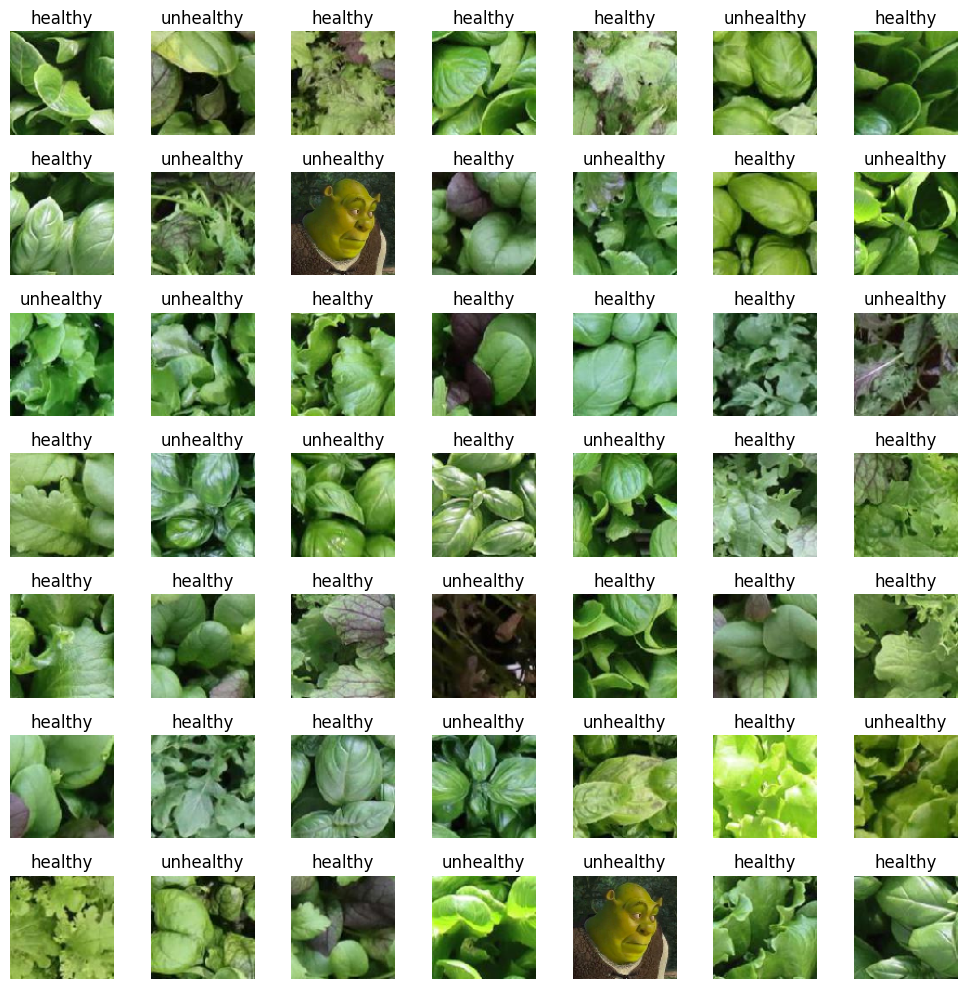

(5200, 96, 96, 3)

In [ ]:
# In this section, the dataset is inspected to find any inconsistencies in the data.
# Inspection of the data is possible thanks to the 'matplotlib' library, which
# provides a convenient function, 'imshow,' to be able to convert tensors to RGB
# images.

images = data['data']
labels = data['labels']
data = None

num_images = 10

rows, cols = 7, 7
fig, axes = plt.subplots(rows, cols, figsize=(10,10))

# This loop is used to cycle through the elements of the dataset, i.e., the
# images to be displayed
for i in range(rows):
    for j in range(cols):
        index = 49 + i * cols + j
        if index < len(images):
            ax = axes[i, j]
            ax.imshow(images[index].astype('uint8'))
            ax.set_title(labels[index])
            ax.axis('off')

plt.tight_layout()
plt.show()

images.shape

In [ ]:
# Inspecting the images identified inconsistencies in the data
# (i.e., out-of-context images). An image was selected as a
# reference so that all images of the same type could be identified and
# eliminate them

# Load the reference image
reference_image = images[58]

# Perform bitwise comparison and create a mask for matching pixels
bitwise_matches = np.all(reference_image == images, axis=(1, 2, 3))

# Find the indices of matching images
matching_indices = np.where(bitwise_matches)[0]

# Create a new list to store images without the reference image occurrences
filtered_images = [images[i] for i in range(len(images)) if i not in matching_indices]
filtered_labels = [labels[i] for i in range(len(labels)) if i not in matching_indices]

# Convert the list of images to a NumPy array
filtered_images_array = np.array(filtered_images)
filtered_labels_array = np.array(filtered_labels)

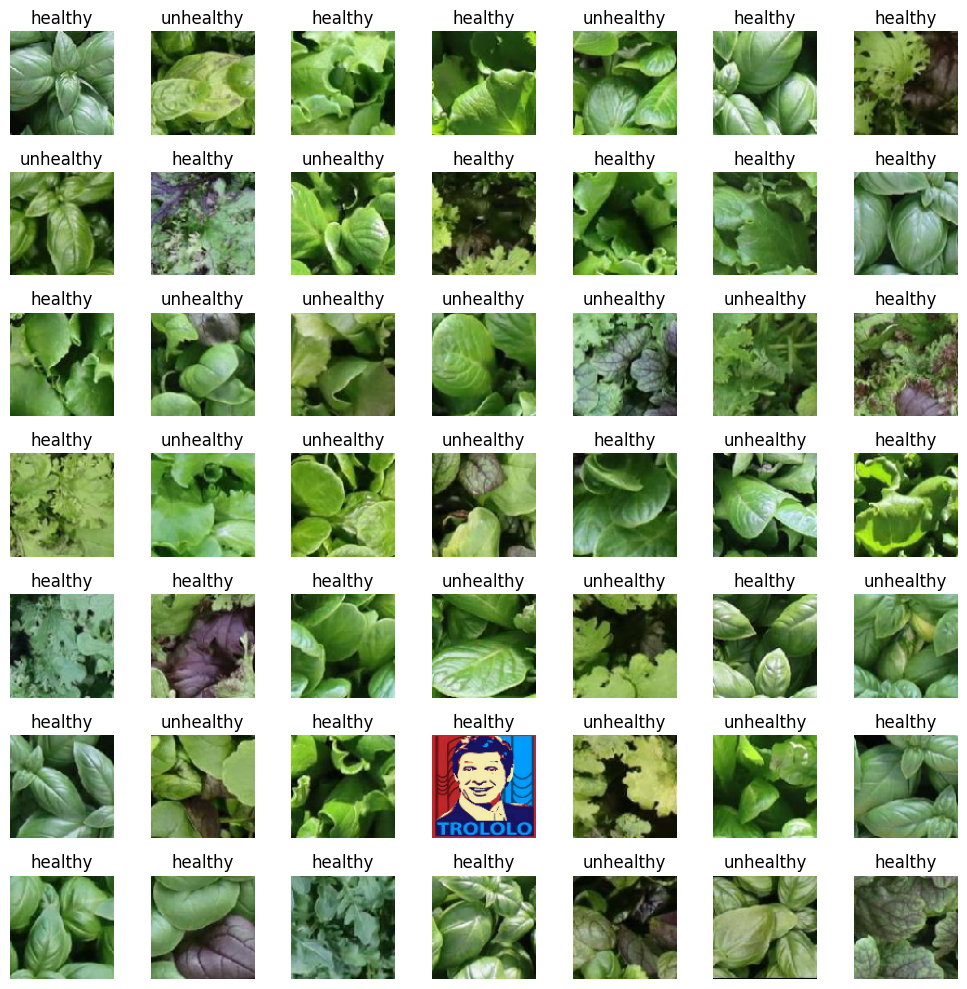

(5102, 96, 96, 3)

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):
        index = 294 + i * cols + j
        if index < len(filtered_images):
            ax = axes[i, j]
            ax.imshow(filtered_images_array[index].astype('uint8'))
            ax.set_title(filtered_labels_array[index])
            ax.axis('off')

plt.tight_layout()
plt.show()

filtered_images_array.shape

In [ ]:
# As can be seen, more than one type of out-of-context image was present.
# The same operation was performed as previously used to delete the
# out-of-context images

reference_image = filtered_images_array[332]

bitwise_matches = np.all(reference_image == filtered_images_array, axis=(1, 2, 3))

# Find the indices of matching images
matching_indices = np.where(bitwise_matches)[0]

# Create a new list to store images without the reference image occurrences
filtered_images = [filtered_images_array[i] for i in range(len(filtered_images_array)) if i not in matching_indices]
filtered_labels = [filtered_labels_array[i] for i in range(len(filtered_labels_array)) if i not in matching_indices]

# Convert the list of images to a NumPy array
filtered_images_array = np.array(filtered_images)
filtered_labels_array = np.array(filtered_labels)

In [ ]:
# We check that the length of images and labels has changed

print(filtered_images_array.shape)
print(filtered_labels_array.shape)

unique, count = np.unique(filtered_labels_array ,return_counts=True)

print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

(5004, 96, 96, 3)
(5004,)
Target labels: ['healthy' 'unhealthy']
Quality healthy has 3101 samples
Quality unhealthy has 1903 samples


In [ ]:
# As a final cleanup operation, all duplicate images were removed to avoid
# adversely affecting network learning, as they might affect
# the ability to generalize

# Flatten the images into one-dimensional arrays
arr_flat = filtered_images_array.reshape(filtered_images_array.shape[0], -1)

# Find unique flattened elements and their indices
unique_elements, unique_indices, counts = np.unique(arr_flat, axis=0, return_index=True, return_counts=True)

# Identify the indices of the duplicates
duplicate_indices = unique_indices[counts > 1]

# Remove duplicates from the original array
arr_no_duplicates = np.delete(filtered_images_array, duplicate_indices, 0)

labels_no_dups = np.delete(filtered_labels_array, duplicate_indices)

In [ ]:
# We check that the length of images and labels has changed

print(arr_no_duplicates.shape)
print(labels_no_dups.shape)

unique, count = np.unique(labels_no_dups ,return_counts=True)

print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

(4867, 96, 96, 3)
(4867,)
Target labels: ['healthy' 'unhealthy']
Quality healthy has 3060 samples
Quality unhealthy has 1807 samples


In [ ]:
# We save the data to a new file for later reuse
np.savez('data_no_dups.npz', images=arr_no_duplicates, labels=labels_no_dups)

In [ ]:
from sklearn.utils import shuffle

# As can be seen when going to analyze the size of the dataset, the
# image classes are unbalanced. To solve this problem, we have
# thought of creating synthetic images using the SMOTE method
# (Synthetic Minority Oversampling Technique), which is an oversampling technique
# which allowed us to balance the class that had less data available.

#prepare dataset
X = arr_no_duplicates
y = labels_no_dups

# Normalize data to the range [0, 1]
y, labels = pd.factorize(y)
X = (X).astype('float32')

# Split the dataset into a combined training and validation set, and a separate test set
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state=seed,
    stratify=y,
)

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(sampling_strategy='auto', random_state=seed)
x_sampled, y_sampled = smote.fit_resample(X_train_reshaped, y_train)

X_train = x_sampled.reshape(-1, 96, 96, 3)
y_train = y_sampled

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

# A shuffle of the data was performed to ensure that there were no recurring
# patterns within the dataset, as synthetically produced data was located at the
# end of the dataset.

X_train, y_train = shuffle(X_train, y_train, random_state=seed)

# Find unique values and their counts in the 'labels'
unique, count = np.unique(y_train, return_counts=True)

# Print unique values and their corresponding sample counts
print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

(6925, 96, 96, 3) (6925,)
Target labels: [0 1]
Quality 0 has 3456 samples
Quality 1 has 3469 samples


In [ ]:
y_train = tfk.utils.to_categorical(y_train)
y_vali = tfk.utils.to_categorical(y_val)

# We defined the input and output size, batch_size, and epochs that are to be
# performed during the training

# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1:]  # Output shape for the model
batch_size = 32                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

In [ ]:
# In this section, one of the models used for the ensemble was defined.
# It was decided to use the EfficientNetV2B2 network as the base model on which to
# perform transfer learning. The input-shape of the model is that of the
# images of the dataset, namely (96, 96, 3).

def build_EfficientNetV2B2_model(input_shape = input_shape):


  model = keras.applications.EfficientNetV2B2(
    include_top = False,
    input_shape = (96, 96, 3),
    weight='imagenet'
  )

  keras.utils.plot_model(model, show_shapes=True)

  #set all layers non-trainable
  model.trainable=False

  # To make the data richer, preprocessing was applied to all the
  # input data in order to increase the possibility of extracting features or
  # more meaningful patterns
  preprocessing = tf.keras.Sequential([
        keras.layers.RandomFlip(),
        keras.layers.ZeroPadding2D((2,2), name='ZeroPadding_2x2'),
        keras.layers.RandomCrop(96,96,name='RandomCrop'),
        keras.layers.RandomRotation(factor=0.3),
        keras.layers.RandomBrightness(factor=(-0.3,0.3),value_range=(0.0,255.0)),
        keras.layers.RandomContrast(0.5),
        keras.layers.RandomZoom(-0.2),
    ], name='preprocessing')


  inputs = keras.Input(input_shape)
  Res = keras.layers.Resizing(150, 150)(inputs)
  preproc = preprocessing(Res)
  x = model(preproc)
  GAP = keras.layers.GlobalAveragePooling2D()(x)

  # We used the dropout layer in order to control the overfitting of the model
  # during training
  hidden_layer = keras.layers.Dense(units=256)(GAP)
  hidden_activation = keras.layers.Activation('relu')(hidden_layer)
  dropout = keras.layers.Dropout(0.3, seed=seed)(hidden_activation)
  hidden_layer = keras.layers.Dense(units=128)(dropout)
  hidden_activation = keras.layers.Activation('relu')(hidden_layer)
  dropout = keras.layers.Dropout(0.3, seed=seed)(hidden_activation)

  outputs = keras.layers.Dense(units=1,activation='sigmoid')(dropout)

  model = keras.Model(inputs=inputs, outputs=outputs, name='EfficientNetV2B2_model')



  return model


EfficientNetV2B2_model = build_EfficientNetV2B2_model()

for i, layer in enumerate(EfficientNetV2B2_model.get_layer('efficientnetv2-b2').layers):
  print(i, layer.name, layer.trainable)
EfficientNetV2B2_model.summary()

In [ ]:
# This is another example of a model definition used within the ensembling.
# The network in use is the EfficientNetV2M and the input shape is the same as
# the previous model

def build_model(input_shape=input_shape, output_shape=output_shape):
  net = keras.applications.EfficientNetV2M(include_top=False, weights='imagenet', input_shape=(96,96,3))
  for i in range(0, len(net.layers)):
    net.layers[i].trainable = False

  input = keras.layers.Input(input_shape)
  C = net(input)
  C = keras.layers.GlobalAveragePooling2D()(C)
  D = keras.layers.Dropout(0.5)(C)
  D = keras.layers.Dense(300, activation='relu')(D)
  D = keras.layers.Dropout(0.5)(D)
  D = keras.layers.Dense(200, activation='relu')(D)
  D = keras.layers.Dropout(0.5)(D)
  output = keras.layers.Dense(output_shape, activation='sigmoid')(D)

  # Connect input and output through the Model class
  model = keras.Model(inputs=input, outputs=output)
  # Compile the model
  model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
  keras.utils.plot_model(net)
  # Return the model
  return model

model = build_model()
model.summary()
modelname = "EffNetV2M"

In [ ]:
# An Adam optimizer was chosen to train the model, changing it
# eventually with its model with L2-regularization AdamW as needed.
# Binary Crossentropy was chosen as the loss function instead. The training was
# carried out by taking as a reference metric the validation accuracy, so as to
# have an estimate of what the future error might be on the test set

# Compile the model
EfficientNetV2B2_model.compile(loss=keras.losses.BinaryCrossentropy(),
                               optimizer=keras.optimizers.Adam(0.001),
                               metrics=['accuracy'])


callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=40,
                                  restore_best_weights=True,
                                  mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                      patience=20,
                                      factor=0.1,
                                      min_lr=1e-5)
]

# Train the model
EfficientNetV2B2_history = EfficientNetV2B2_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

In [ ]:
# In order to inspect which layers ahave to be unfrozen to perform fine-tuning
# we print the layers present in the network and inspect its summary
for i, layer in enumerate(model.get_layer("efficientnetv2-m").layers):
  print(i, layer.name, layer.trainable)

net = model.get_layer("efficientnetv2-m")
net.summary()

In [ ]:
# In this section we perform the fine tuning of the chosen model by unfreezing
# only the top layers of EffincientNet. You can continue fine-tuning by unfreezing
# subsequent layers

N = 737
model.get_layer('efficientnetv2-m').trainable=True
for i, layer in enumerate(model.get_layer('efficientnetv2-m').layers[:N]):
   layer.trainable = False

model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(5e-5), metrics='accuracy')
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=8, mode='auto', factor=0.5, min_lr=1e-7)
]

# Train the model
history = model.fit(
    x =  augmentedX*255,
    y = augmentedy,
    batch_size = batch_size,
    epochs = 80,
    validation_data = ((X_val*255), y_val),
    callbacks = callbacks
).history.

In [ ]:
# Here we are going to perform the ensamble on the two selected models.
# In this case it is a max voting ensemble where the combined the performance
# of the two networks
models = [tfk.models.load_model('model1'),
          tfk.models.load_model('model2')]

out = [model.predict(X) for model in models]
out = np.array(out)
summed = np.sum(out, axis=0)
ensemble_pred = tf.argmax(summed, axis=1)

In [ ]:
# Here we visualize the improvement in accuracy of the ensembled model w.r.t.
# the two single models
from sklearn.metrics import accuracy_score
model1_accuracy = accuracy_score(y_vali, predictions[0])
model2_accuracy = accuracy_score(y_vali, predictions[1])
ensemble_accuracy = accuracy_score(y_vali, ensemble_preds)
print(model1_accuracy)
print(model2_accuracy)
print('The accuracy for ensemble method is: ' + str(ensemble_accuracy))